In [1]:
import numpy as np
from scipy import io as sio
from matplotlib import pyplot as plt
import inspect

In [2]:
# Define a function to see the source code of a function. 
def showfunc(functiontoshow):
    print(inspect.getsource(functiontoshow))

In [3]:
import typhon as tp

In [4]:
# Set input frequency values.

# Case 1
# f_grid = np.array([18.700e9, 22.235e9, 37.000e9, 40.000e9, 
#                    50.300e9, 52.300e9, 53.600e9, 54.550e9, 55.750e9, 
#                    57.000e9, 58.400e9, 59.800e9])

# Case 2
f_grid = np.array([ 22.234e9, 22.5e9, 23.034e9, 23.834e9, 
                    25e9, 26.234e9, 28e9, 30e9, 
                    51.248e9, 51.76e9, 52.28e9, 52.804e9, 
                    53.336e9, 53.848e9, 54.4e9, 54.94e9, 
                    55.5e9, 56.02e9, 56.66e9, 57.288e9, 57.964e9, 58.8e9 ])
                   
tp.arts.xml.save(f_grid, './ClearSky_1D_f_grid.xml')

In [5]:
# Set sensor viewing angles and position.

# Case 1
# sensor_los = np.array([[171.030788, 90]]) # Looking down at an angle.
# sensor_pos = np.array([[5334.194, 34.511312, 127.224312]]) # Sensor altitude and geolocation.

# Case 2
sensor_los = np.array([[0, 0]]) # Looking straight up
sensor_pos = np.array([[0, 34.763892, 127.212426]]) # Bosung, Korea

# Sensor LOS azimuth and geolocation do not matter since it is 1-D calculation.
tp.arts.xml.save(np.array([[sensor_los[0,0]]]), './ClearSky_1D_sensor_los.xml')
tp.arts.xml.save(np.array([[sensor_pos[0,0]]]), './ClearSky_1D_sensor_pos.xml')

In [6]:
# Load surface and atmosphere datasets from netCDF input files. 
surface_dataset = sio.netcdf.netcdf_file('./l015v070erlounish000.2017093000.rec.nc',mmap=False)
atmosphere_dataset = sio.netcdf.netcdf_file('./l015v070erlopresh000.2017093000.rec.nc',mmap=False)

In [7]:
# Load variables from the surface dataset. 
surface_lat = surface_dataset.variables['lat'][:]
surface_lon = surface_dataset.variables['lon'][:]
sf_pressure = surface_dataset.variables['sp'][:]
sf_temperature = surface_dataset.variables['t_2'][:]
sf_RH = surface_dataset.variables['r'][:]

# Variables' sizes
surface_lat_size = len(surface_lat)
surface_lon_size = len(surface_lon)

In [8]:
# Load variables from the atmospheric dataset.
atm_pressure = atmosphere_dataset.variables['lev'][:]
atm_lat = atmosphere_dataset.variables['lat'][:]
atm_lon = atmosphere_dataset.variables['lon'][:]
atm_temperature = atmosphere_dataset.variables['t'][0,:]  
atm_gH = atmosphere_dataset.variables['gh'][0,:] # Geopotential height
atm_RH = atmosphere_dataset.variables['r'][0,:] # Relative humidity 
# atm_RH_Ice = atmosphere_dataset.variables['param194.1.0'][:]  

# Variables' sizes
atm_lat_size = len(atm_lat)
atm_lon_size = len(atm_lon)
atm_pre_size = len(atm_pressure)

In [9]:
# Find the geolocation of the pixel that is closest to the geolocation of the sensor's line-of-sight (LOS). 

In [10]:
# Assume WGS 1984 for the reference Ellipsoid.
R_eq = 6378137 # Earth's equatorial radius, in meters
iFlttn = 298.257223563 # Inverse flattening
R_polar = R_eq * (1-1/iFlttn) # Earth's polar radius
eccnty = (2/iFlttn - (1/iFlttn)**2)**0.5 # Eccentricity of the ellipsoid 

In [11]:
# Sensor LOS and position
sensor_pos_alt = sensor_pos[0,0]
sensor_pos_lat = sensor_pos[0,1]
sensor_pos_lon = sensor_pos[0,2]

sensor_los_zen = sensor_los[0,0]
sensor_los_azi = sensor_los[0,1]

# Convert the sensor's position from polar to Cartesian coordinates.
# 국지예보모델 is based on the Unified Model from UK Met Office, which uses rotated spherical coordinates system. 
# For now, assume that it is corresponding to geodetic coordinates system on WGS84.
N_radius = R_eq/((1-(eccnty**2)*(np.sin(sensor_pos_lat * np.pi/180)**2))**0.5)
sensor_pos_cart = np.array([ (N_radius+sensor_pos_alt) * np.cos(sensor_pos_lat * np.pi/180) * np.cos(sensor_pos_lon * np.pi/180), 
    (N_radius+sensor_pos_alt) * np.cos(sensor_pos_lat * np.pi/180) * np.sin(sensor_pos_lon * np.pi/180), 
    ((1-eccnty**2)*N_radius+sensor_pos_alt) * np.sin(sensor_pos_lat * np.pi/180) ]) # Cartesian coordinates of the sensor's position

In [12]:
# Find the sensor LOS' equation. 
# Find the local reference vectors for the sensor's zenith and azimuth. 
if (sensor_pos_alt == 0):
    sensor_los_localZ = -np.array([sensor_pos_cart[0]/((R_eq)**2), 
                                    sensor_pos_cart[1]/((R_eq)**2), 
                                    sensor_pos_cart[2]/((R_polar)**2)])
elif (sensor_pos_alt > 0):
    sensor_pos_ground = np.array([(N_radius) * np.cos(sensor_pos_lat * np.pi/180) * np.cos(sensor_pos_lon * np.pi/180), 
                                  (N_radius) * np.cos(sensor_pos_lat * np.pi/180) * np.sin(sensor_pos_lon * np.pi/180), 
                                  ((1-eccnty**2)*N_radius) * np.sin(sensor_pos_lat * np.pi/180) ])     
    sensor_los_localZ = sensor_pos_ground - sensor_pos_cart
# Throw an error if the sensor altitude is not properly defined. 
else:
    raise Exception('Wrong sensor altitude! \n')

sensor_pos2NorthPole = np.array([0, 0, R_polar]) - sensor_pos_cart
sensor_pos2North = sensor_pos2NorthPole - ((np.dot(sensor_pos2NorthPole,sensor_los_localZ) / np.dot(sensor_los_localZ,sensor_los_localZ)) * sensor_los_localZ)
sensor_los_localX = sensor_pos2North
sensor_los_localY = np.cross(sensor_los_localZ,sensor_los_localX)
    
# Normalize the local axes for sensor_los.
sensor_los_localZ = sensor_los_localZ / np.linalg.norm(sensor_los_localZ)
sensor_los_localY = sensor_los_localY / np.linalg.norm(sensor_los_localY)
sensor_los_localX = sensor_los_localX / np.linalg.norm(sensor_los_localX)
    
# Calculate the sensor's LOS vector in reference to the Earth.
sensor_los_theta = (sensor_los_zen - 90) * np.pi/180
sensor_los_phi = (sensor_los_azi) * np.pi/180
sensor_los_vec = np.array([np.cos(sensor_los_theta) * np.cos(sensor_los_phi), 
                           np.cos(sensor_los_theta) * np.sin(sensor_los_phi), 
                           np.sin(sensor_los_theta) ])
sensor_los_vec_global = (sensor_los_vec[0]*sensor_los_localX + sensor_los_vec[1]*sensor_los_localY + sensor_los_vec[2]*sensor_los_localZ)

In [13]:
# Find the sensor LOS' ground location. 
# If the sensor is on the ground: 
if (sensor_pos_alt == 0):
    sensor_los_gpos = sensor_pos_cart

# If the sensor is above the ground looking down: 
elif (sensor_pos_alt > 0):
    # Calculate the intersection between the Earth's ellipsoid and the sensor's LOS, using the quadratic formula. 
    a = (R_polar**2) * (sensor_los_vec_global[0]**2 + sensor_los_vec_global[1]**2) + (R_eq**2) * (sensor_los_vec_global[2]**2)
    b = 2 * ((R_polar**2) * (sensor_los_vec_global[0]*sensor_pos_cart[0] + sensor_los_vec_global[1]*sensor_pos_cart[1]) + (R_eq**2) * sensor_los_vec_global[2]*sensor_pos_cart[2])
    c = (R_polar**2) * (sensor_pos_cart[0]**2 + sensor_pos_cart[1]**2) + (R_eq**2) * (sensor_pos_cart[2]**2) - (R_polar**2)*(R_eq**2)
    t = np.array([(-b + (b**2 - 4*a*c)**0.5)/(2*a), (-b - (b**2 - 4*a*c)**0.5)/(2*a)])

    sensor_los_gpos_cand = sensor_pos_cart + np.matrix(t).T*np.matrix(sensor_los_vec_global)
    sensor_los_gpos_cand_dist = np.linalg.norm(sensor_pos_cart - sensor_los_gpos_cand,axis=1)
    sensor_los_gpos_cand_dist_which = sensor_los_gpos_cand_dist < np.mean(sensor_los_gpos_cand_dist)
    sensor_los_gpos = sensor_los_gpos_cand[sensor_los_gpos_cand_dist_which,:]
    sensor_los_gpos = np.array(sensor_los_gpos)[0]

In [14]:
# Extend the variables' dimensions to 2-D for vectorization. 
surface_lat_ext = np.tile(surface_lat.reshape(surface_lat_size,1),(1,surface_lon_size))
surface_lon_ext = np.tile(surface_lon.reshape(1,surface_lon_size),(surface_lat_size,1))

In [15]:
# Calculate the Cartesian coordinates of the surface pixels. 
# 국지예보모델 is based on the Unified Model from UK Met Office, which uses rotated spherical coordinates system. 
# For now, assume that it is corresponding to geodetic coordinates system on WGS84.
N_radius = R_eq/((1-(eccnty**2)*(np.sin(surface_lat_ext * np.pi/180)**2))**0.5)
surface_pixel_cart = np.array([ (N_radius) * np.cos(surface_lat_ext * np.pi/180) * np.cos(surface_lon_ext * np.pi/180), 
    (N_radius) * np.cos(surface_lat_ext * np.pi/180) * np.sin(surface_lon_ext * np.pi/180), 
    ((1-eccnty**2)*N_radius) * np.sin(surface_lat_ext * np.pi/180) ]) 

In [16]:
# Find the indices of the pixel closest to the sensor_los ground location. 
surface_pixel_cart_diff = surface_pixel_cart - np.expand_dims((np.expand_dims(sensor_los_gpos,axis=1)),axis=1)
surface_pixel_cart_dist = np.zeros((surface_lat_size,surface_lon_size))

for i in range(surface_lat_size):
    for j in range(surface_lon_size):
        surface_pixel_cart_dist[i,j] = np.linalg.norm(surface_pixel_cart_diff[:,i,j])

sensor_los_sf_indices = np.unravel_index(np.argmin(surface_pixel_cart_dist),(surface_lat_size,surface_lon_size))
sensor_los_sf_indices

(171, 127)

In [17]:
# Create p_grid and save as xml. 
# Find the surface pressure value at the sensor's LOS, by nearest neighbor interpolation. 
sf_pressure_select = sf_pressure[0,sensor_los_sf_indices[0],sensor_los_sf_indices[1]]
pressure = np.append(sf_pressure_select, atm_pressure)
tp.arts.xml.save(pressure, './ClearSky_1D_p_grid.xml')

In [18]:
# Extend the variables' dimensions to 3-D for vectorization. 
atm_lat_ext = np.array(np.tile(atm_lat.reshape(1,atm_lat_size,1),(atm_pre_size,1,atm_lon_size)))
atm_lon_ext = np.array(np.tile(atm_lon.reshape(1,1,atm_lon_size),(atm_pre_size,atm_lat_size,1)))

In [19]:
# Create z_field and save as xml. 
# Reference (accessed 2018-07-02): 
# http://glossary.ametsoc.org/wiki/Geopotential_height
# http://glossary.ametsoc.org/wiki/Acceleration_of_gravity 
g0 = 9.80665 # Standard gravity at sea level 
g_lat = 0.01*(980.6160*(1 - 0.0026373*np.cos(np.pi/180 * 2*atm_lat_ext) + 0.0000059*(np.cos(np.pi/180 * 2*atm_lat_ext)**2))) # Sea-level gravity at given latitude
Cg = 0.01*(3.085462*(10**-4) + 2.27*(10**-7)*np.cos(np.pi/180*2*atm_lat_ext)) # The coefficient in the gravity equation. 

# Solve for geometric height, using the quadratic formula.
a = Cg/2
b = -g_lat
c = g0*atm_gH
atm_z = (-b - (b**2 - 4*a*c)**0.5)/(2*a)
# Here, the geopotential height is given based on 국지예보모델, so the calculated z field may be based on a spherical coordinates system.
# ARTS requires z field that is defined in terms of the geometrical altitude, 
# which is the distance between the ellipsoid's surface and the point along the line passing through the Earth's center and the point. 
# For now, assume that the difference between the two systems in this regard is negligible. 

In [20]:
# Calculate the Cartesian coordinates of the atmospheric voxels. 
# 국지예보모델 is based on the Unified Model from UK Met Office, which uses rotated spherical coordinates system. 
# For now, assume that it is corresponding to geodetic coordinates system on WGS84.
N_radius = R_eq/((1-(eccnty**2)*(np.sin(atm_lat_ext * np.pi/180)**2))**0.5)
atm_voxel_cart = np.array([ (N_radius + atm_z) * np.cos(atm_lat_ext * np.pi/180) * np.cos(atm_lon_ext * np.pi/180), 
                            (N_radius + atm_z) * np.cos(atm_lat_ext * np.pi/180) * np.sin(atm_lon_ext * np.pi/180), 
                            ((1-eccnty**2)*N_radius + atm_z) * np.sin(atm_lat_ext * np.pi/180) ]) 

if (sensor_los_zen == 0 or sensor_los_zen == 180):
    # If the sensor is looking straight up or down: 
    atm_z_field = atm_z[:,sensor_los_sf_indices[0],sensor_los_sf_indices[1]]
    sensor_los_atm_indices = np.zeros((atm_pre_size,2),dtype=int)
    sensor_los_atm_indices[:,0] = sensor_los_sf_indices[0]
    sensor_los_atm_indices[:,1] = sensor_los_sf_indices[1]
else:
    atm_z_field = np.zeros(atm_pre_size)
    sensor_los_atm_indices = np.zeros((atm_pre_size,2),dtype=int)
    # Compare the Cartesian distance between the sensor LOS line and the atmospheric voxels.
    for i in range(atm_pre_size):
        atm_voxel_cart_slice = atm_voxel_cart[:,i,:,:]
        t = (sensor_pos_cart[0]*sensor_los_vec_global[0] - atm_voxel_cart_slice[0,:,:]*sensor_los_vec_global[0] 
             + sensor_pos_cart[1]*sensor_los_vec_global[1] - atm_voxel_cart_slice[1,:,:]*sensor_los_vec_global[1] 
             + sensor_pos_cart[2]*sensor_los_vec_global[2] - atm_voxel_cart_slice[2,:,:]*sensor_los_vec_global[2]) /(-(np.linalg.norm(sensor_los_vec_global)**2))
        dist = np.linalg.norm( np.tile(t,(3,1,1))*np.tile(np.reshape(sensor_los_vec_global,(3,1,1)),(1,atm_lat_size,atm_lon_size)) 
               + np.tile(np.reshape(sensor_pos_cart,(3,1,1)),(1,atm_lat_size,atm_lon_size)) - atm_voxel_cart_slice, axis=0)
        sensor_los_atm_indices[i,] = np.unravel_index(np.argmin(dist),(atm_lat_size,atm_lon_size))
        atm_z_field[i] = atm_z[i,sensor_los_atm_indices[i,0],sensor_los_atm_indices[i,1]]

z_field = np.append(0, atm_z_field)
# Save z_field as GriddedField3 xml file. 
z_field_GF3 = tp.arts.griddedfield.GriddedField3()
z_field_GF3.data = np.reshape(z_field,(atm_pre_size+1,1,1))
z_field_GF3.grids = [pressure, np.array([0]), np.array([0])]
z_field_GF3.gridnames = ['Pressure', 'Latitude', 'Longitude']
tp.arts.xml.save(z_field_GF3, './ClearSky_1D.z.xml')
sensor_los_atm_indices

array([[171, 127],
       [171, 127],
       [171, 127],
       [171, 127],
       [171, 127],
       [171, 127],
       [171, 127],
       [171, 127],
       [171, 127],
       [171, 127],
       [171, 127],
       [171, 127],
       [171, 127],
       [171, 127],
       [171, 127],
       [171, 127],
       [171, 127],
       [171, 127],
       [171, 127],
       [171, 127],
       [171, 127],
       [171, 127],
       [171, 127],
       [171, 127]])

In [21]:
# Create temperature and save as xml. 
# Find the surface temperature value at the sensor's LOS, by nearest neighbor interpolation. 
sf_temperature_select = sf_temperature[0,sensor_los_sf_indices[0],sensor_los_sf_indices[1]]

# Find atmospheric voxels nearest to the sensor LOS. 
atm_temperature_LOS = np.zeros(atm_pre_size)
for i in range(atm_pre_size):
    atm_temperature_LOS[i] = atm_temperature[i,sensor_los_atm_indices[i,0],sensor_los_atm_indices[i,1]]

t_field = np.append(sf_temperature_select, atm_temperature_LOS)

# Save t_field as GriddedField3 xml file. 
t_field_GF3 = tp.arts.griddedfield.GriddedField3()
t_field_GF3.data = np.reshape(t_field,(atm_pre_size+1,1,1))
t_field_GF3.grids = [pressure, np.array([0]), np.array([0])]
t_field_GF3.gridnames = ['Pressure', 'Latitude', 'Longitude']
tp.arts.xml.save(t_field_GF3, './ClearSky_1D.t.xml')

In [22]:
# Create H2O VMR and save as xml.
# Find the surface relative humidity value at the sensor's LOS, by nearest neighbor interpolation. 
sf_RH_select = sf_RH[0,0,sensor_los_sf_indices[0],sensor_los_sf_indices[1]]

# Find atmospheric voxels nearest to the sensor LOS. 
atm_RH_LOS = np.zeros(atm_pre_size)
for i in range(atm_pre_size):
    atm_RH_LOS[i] = atm_RH[i,sensor_los_atm_indices[i,0],sensor_los_atm_indices[i,1]]

RH = np.append(sf_RH_select, atm_RH_LOS) * 0.01

# Convert the water RH to VMR. 
VMR_H2O = tp.physics.relative_humidity2vmr(RH, pressure, t_field)

# Save Water VMR as GriddedField3 xml file. 
VMR_H2O_GF3 = tp.arts.griddedfield.GriddedField3()
VMR_H2O_GF3.data = np.reshape(VMR_H2O,(atm_pre_size+1,1,1))
VMR_H2O_GF3.grids = [pressure, np.array([0]), np.array([0])]
VMR_H2O_GF3.gridnames = ['Pressure', 'Latitude', 'Longitude']
tp.arts.xml.save(VMR_H2O_GF3, './ClearSky_1D.H2O.xml')

In [23]:
# ARTS forward model: 
tp.arts.run_arts(controlfile='./ClearSky_1D_ARTSvdev.arts')

ARTS_output(stdout='Executing ARTS.\nCommand line:\narts ./ClearSky_1D_ARTSvdev.arts \nVersion: arts-2.3.1088\nExecuting Arts\n{\n- verbosityInit\n- scat_speciesSet\n- MatrixSet\n- Tensor4SetConstant\n- ArrayOfStringSet\n- Touch\n- Tensor3SetConstant\n- ArrayOfStringSet\n- MatrixSet\n- NumericSet\n- ArrayOfStringSet\n- Tensor3SetConstant\n- Tensor3SetConstant\n- Tensor3SetConstant\n- Tensor3SetConstant\n- Tensor3SetConstant\n- Tensor3SetConstant\n- IndexSet\n- IndexSet\n- IndexSet\n- IndexSet\n- FlagOff\n- output_file_formatSetAscii\n- StringSet\n- IndexSet\n- abs_lineshapeDefine\n- NumericSet\n- NumericSet\n- AgendaSet\n- IndexSet\n- IndexSet\n- NumericSet\n- NumericSet\n- nlteOff\n- partition_functionsInitFromBuiltin\n- AgendaSet\n- IndexSet\n- abs_cont_descriptionInit\n- abs_cont_descriptionAppend\n- abs_cont_descriptionAppend\n- abs_cont_descriptionAppend\n- abs_cont_descriptionAppend\n- abs_cont_descriptionAppend\n- abs_cont_descriptionAppend\n- abs_cont_descriptionAppend\n- abs_c

In [24]:
# ARTS forward model results. 
Tb_ARTS_ClearSky = tp.arts.xml.load("./ClearSky_1D_Tb.xml")

# Bosung observations, 20170930
Tb_BosungObs = np.array([26.193, 23.754, 22.435, 18.510, 
                         15.617, 12.566, 12.388, 11.472, 
                         107.09, 123.677, 147.536, 178.933, 
                         216.787, 250.225, 273.193, 282.353, 
                         286.576, 288.430, 289.69, 290.449, 
                         291.361, 291.436]) 
tp.arts.xml.save(Tb_BosungObs, './BosungObservations.xml')

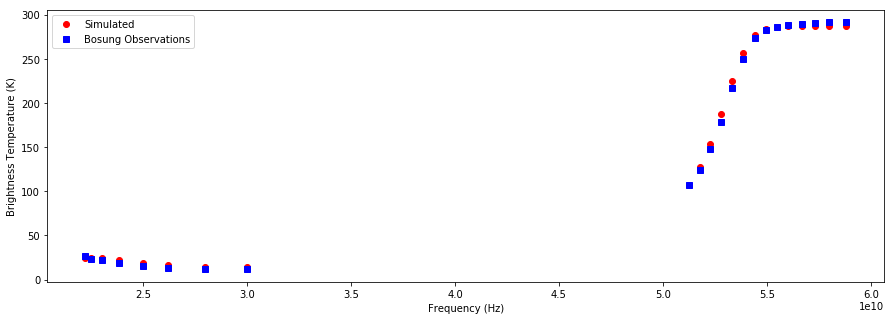

In [25]:
# Compare brightness temperatures from the simulation with the observations. 
plt.plot(f_grid, Tb_ARTS_ClearSky, 'ro', f_grid, Tb_BosungObs, 'bs')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Brightness Temperature (K)')
plt.legend(['Simulated','Bosung Observations'])
plt.gcf().set_size_inches(15,5)

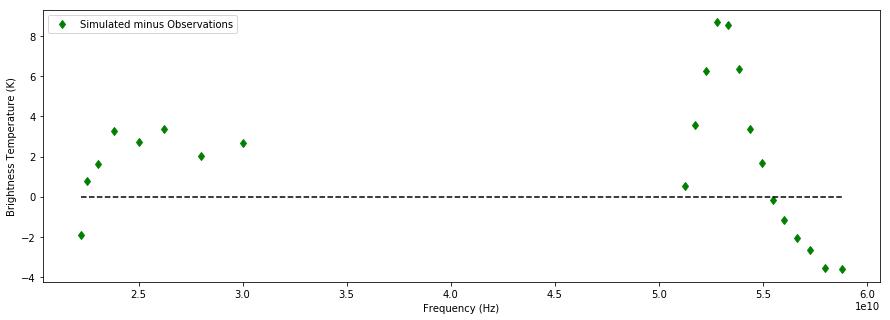

In [26]:
# Plot the difference between the two. 
plt.plot(f_grid, Tb_ARTS_ClearSky - Tb_BosungObs, 'gd', f_grid, np.zeros(f_grid.shape),'k--')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Brightness Temperature (K)')
plt.legend(['Simulated minus Observations'])
plt.gcf().set_size_inches(15,5)

In [27]:
# Check test tropical input data for AtmRawRead. 
tropical_H2O = tp.arts.xml.load('testdata_tropical.H2O.xml').data
tropical_N2 = tp.arts.xml.load('testdata_tropical.N2.xml').data
tropical_O2 = tp.arts.xml.load('testdata_tropical.O2.xml').data
tropical_O3 = tp.arts.xml.load('testdata_tropical.O3.xml').data

tropical_totalVMR =  tropical_H2O + tropical_N2 + tropical_O2 + tropical_O3
tropical_totalVMR

array([[[1.01652841]],

       [[1.01009166]],

       [[1.00614986]],

       [[0.99953708]],

       [[0.99477537]],

       [[0.99430685]],

       [[0.99320792]],

       [[0.99180222]],

       [[0.99191084]],

       [[0.9911265 ]],

       [[0.99090786]],

       [[0.99072838]],

       [[0.99070155]],

       [[0.9908694 ]],

       [[0.99077093]],

       [[0.99070233]],

       [[0.99085965]],

       [[0.99076475]],

       [[0.99089095]],

       [[0.99071905]],

       [[0.990537  ]],

       [[0.99038305]],

       [[0.9907569 ]],

       [[0.9906944 ]],

       [[0.99078091]],

       [[0.99069616]],

       [[0.99057871]],

       [[0.99080021]],

       [[0.99075456]],

       [[0.99067991]],

       [[0.99114922]],

       [[0.99070531]],

       [[0.99079451]],

       [[0.99074251]],

       [[0.99089706]],

       [[0.99068461]],

       [[0.99094621]],

       [[0.9906174 ]],

       [[0.99062936]],

       [[0.9907631 ]],

       [[0.99073068]],

       [[0.99060